## Critical Heat Flux Prediction

Given data about various experimental conditions, let's try to predict the **critical heat flux** for a given experiment. 

We will use a random forest regression model to make our predictions. 

Data Source: https://www.kaggle.com/datasets/saurabhshahane/predicting-heat-flux

### Getting Started

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('Data_CHF_Zhao_2020_ATE.csv')
data

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0
...,...,...,...,...,...,...,...,...,...,...
1860,1861,Richenderfer,plate,1.01,1500,-0.0218,15.0,120.0,10,9.4
1861,1862,Richenderfer,plate,1.01,1500,-0.0434,15.0,120.0,10,10.4
1862,1863,Richenderfer,plate,1.01,2000,-0.0109,15.0,120.0,10,10.8
1863,1864,Richenderfer,plate,1.01,2000,-0.0218,15.0,120.0,10,10.9


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1865 non-null   int64  
 1   author               1865 non-null   object 
 2   geometry             1865 non-null   object 
 3   pressure [MPa]       1865 non-null   float64
 4   mass_flux [kg/m2-s]  1865 non-null   int64  
 5   x_e_out [-]          1865 non-null   float64
 6   D_e [mm]             1865 non-null   float64
 7   D_h [mm]             1865 non-null   float64
 8   length [mm]          1865 non-null   int64  
 9   chf_exp [MW/m2]      1865 non-null   float64
dtypes: float64(5), int64(3), object(2)
memory usage: 145.8+ KB


### Preprocessing

In [12]:
def preprocess_inputs(df):
    df = df.copy()

    # Drop id and author columns
    df = df.drop(['id', 'author'], axis=1)

    # Shuffle the dataset
    df = df.sample(frac=1.0, random_state=1)

    # split df into X and y
    y = df['chf_exp [MW/m2]']
    X = df.drop(['chf_exp [MW/m2]'], axis=1)
    
    return X, y

In [13]:
X, y = preprocess_inputs(data)

In [14]:
X

,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm]
400,tube,6.89,1967,0.1203,12.8,12.8,1930
571,tube,11.03,2034,0.0616,9.3,9.3,762
351,tube,7.00,4069,0.0636,10.8,10.8,864
1479,annulus,13.79,2729,0.0537,5.6,15.2,2134
1371,tube,13.79,690,-0.4854,11.1,11.1,457
...,...,...,...,...,...,...,...
905,tube,13.79,4910,0.1131,4.7,4.7,318
1791,annulus,6.85,2292,0.0330,8.5,24.6,1778
1096,tube,13.79,2116,0.0926,7.8,7.8,591
235,tube,6.89,4042,-0.0008,10.3,10.3,762


In [15]:
pd.get_dummies(X['geometry'].unique(), dtype=int)

,annulus,plate,tube
0,0,0,1
1,1,0,0
2,0,1,0


In [16]:
y

400     2.8
571     3.2
351     3.2
1479    1.7
1371    3.6
       ... 
905     3.0
1791    4.0
1096    2.1
235     4.0
1061    2.0
Name: chf_exp [MW/m2], Length: 1865, dtype: float64

### Building Pipeline

In [17]:
def build_model():

    nominal_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('nominal', nominal_transformer, ['geometry'])
    ], remainder = 'passthrough')
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=1))
    ])

    return model

### Training

In [20]:
kf = KFold(n_splits = 5)

rmses = []

for train_idx, test_idx in kf.split(X):
    X_train = X.iloc[train_idx, :]
    X_test = X.iloc[test_idx, :]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    
    model = build_model()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = np.sqrt(np.mean((y_test - y_pred)**2))

    rmses.append(rmse)

final_rmse = np.mean(rmses)

In [21]:
print("RMSE: {:.2f}".format(final_rmse))

RMSE: 0.63


In [22]:
y_test.describe()

count    373.000000
mean       3.735121
std        1.871956
min        0.900000
25%        2.300000
50%        3.300000
75%        4.600000
max       13.300000
Name: chf_exp [MW/m2], dtype: float64

<Axes: ylabel='Frequency'>

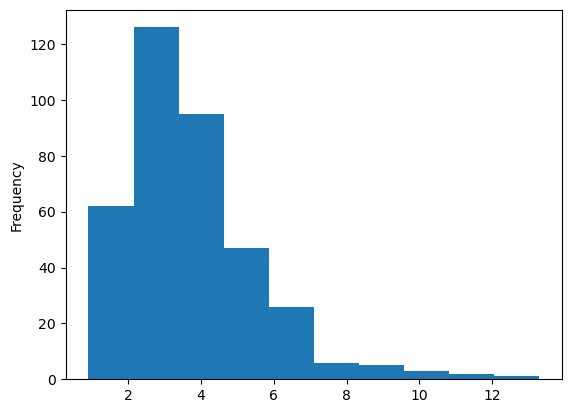

In [23]:
y_test.plot(kind='hist')

In [24]:
rmses

[0.732922385058682,
 0.714811878362217,
 0.5744463822782765,
 0.5767139021499098,
 0.5687141250506902]